# Filtering signal with a butterworth low-pass filter and plotting the STFT of it with a Hanning window and then the Laplace transform. 

## Let's start by generating data. 

Assuming we have a sampling rate of 50 Hz over 10 seconds:

In [1]:
import numpy as np

sample_rate = 50  # 50 Hz resolution
signal_lenght = 10*sample_rate  # 10 seconds
# Generate a random x(t) signal with waves and noise. 
t = np.linspace(0, 10, signal_lenght)
g = 30*( np.sin((t/10)**2) )
x  = 0.30*np.cos(2*np.pi*0.25*t - 0.2) 
x += 0.28*np.sin(2*np.pi*1.50*t + 1.0)
x += 0.10*np.sin(2*np.pi*5.85*g + 1.0)
x += 0.09*np.cos(2*np.pi*10.0*t)
x += 0.04*np.sin(2*np.pi*20.0*t)
x += 0.15*np.cos(2*np.pi*135.0*(t/5.0-1)**2)
x += 0.04*np.random.randn(len(t))
# Normalize between -0.5 to 0.5: 
x -= np.min(x)
x /= np.max(x)
x -= 0.5


## Filtering the generated data: 

Let's keep only what's below 15 Hz with a butterworth low-pass filter of order 4. Sharper cutoff can be obtained with higher orders. 
Butterworth low-pass filters has frequency responses that look like that according to their order: 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Butterworth_Filter_Orders.svg/350px-Butterworth_Filter_Orders.svg.png" alt="Butterworth low-pass filter" style="width: 550px;" />

Let's proceed and filter the data. 

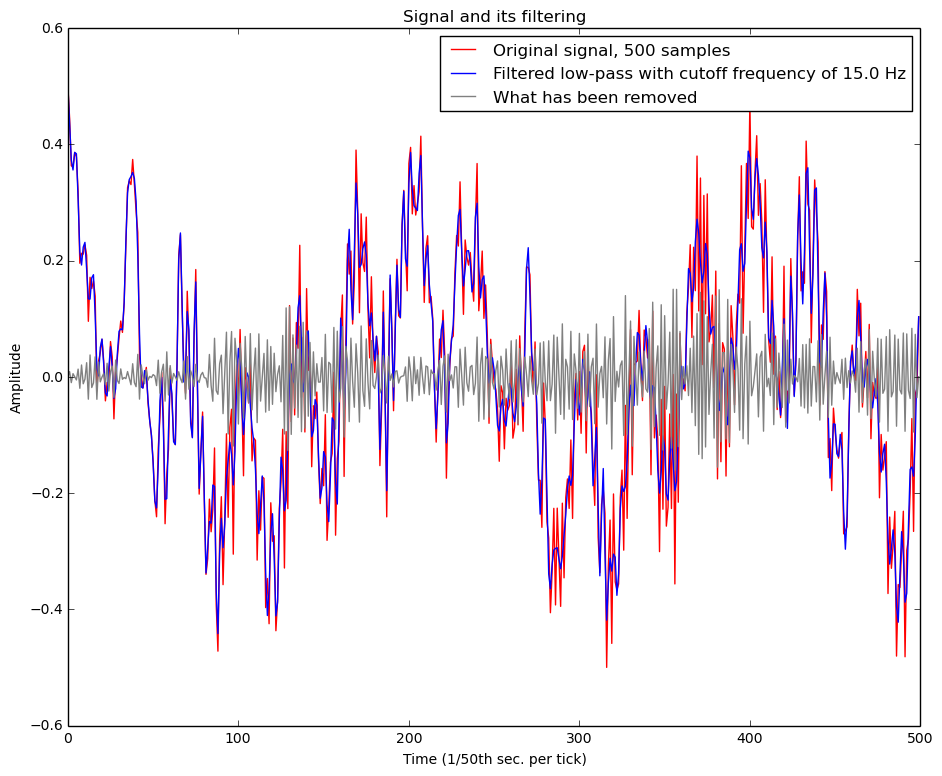

In [2]:
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline 


def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y


# Filter signal x, result stored to y: 
cutoff_frequency = 15.0
y = butter_lowpass_filter(x, cutoff_frequency, sample_rate/2)

# Difference acts as a special high-pass from a reversed butterworth filter. 
diff = np.array(x)-np.array(y)

# Visualize
plt.figure(figsize=(11, 9))
plt.plot(x, color='red', label="Original signal, {} samples".format(signal_lenght))
plt.plot(y, color='blue', label="Filtered low-pass with cutoff frequency of {} Hz".format(cutoff_frequency))
plt.plot(diff, color='gray', label="What has been removed")
plt.title("Signal and its filtering")
plt.xlabel('Time (1/50th sec. per tick)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


## Plotting the spectrum with STFTs. 

Here, the [Hanning window](https://en.wikipedia.org/wiki/Window_function#Hann_.28Hanning.29_window) is used. 

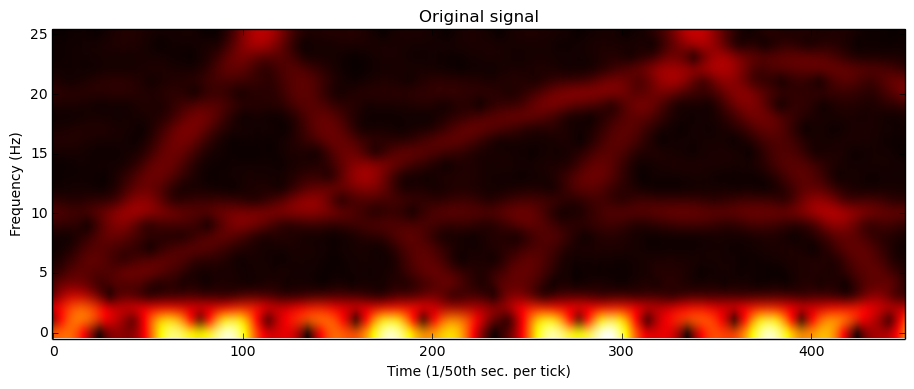

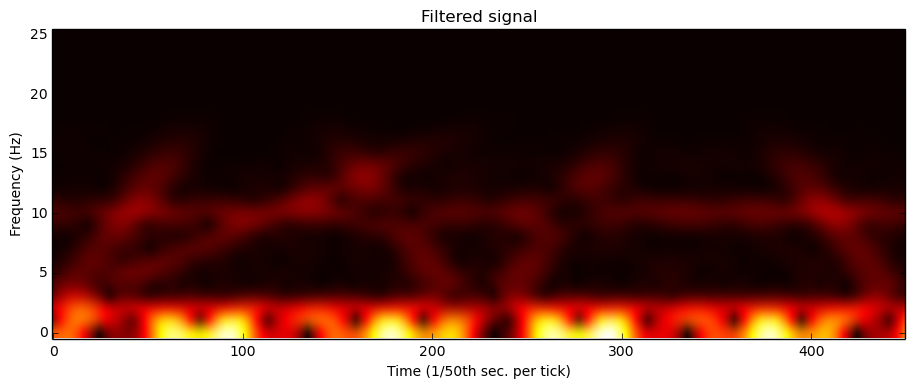

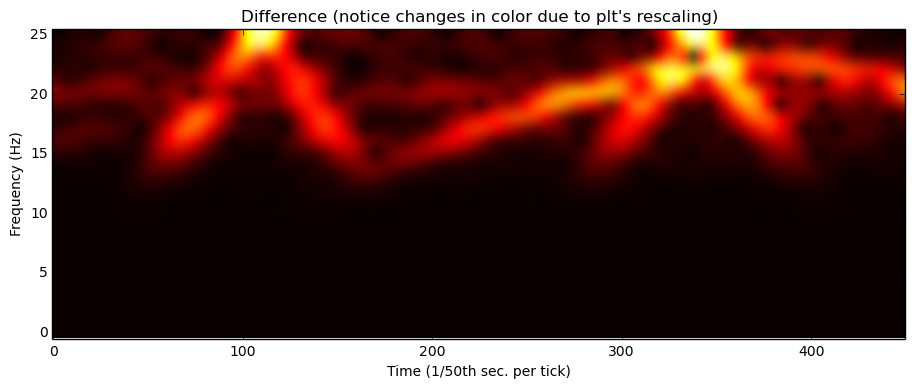

In [3]:
import scipy


def stft(x, fftsize=1024, overlap=4):
    # Short-time Fourier transform
    hop = fftsize / overlap
    w = scipy.hanning(fftsize+1)[:-1]      # better reconstruction with this trick +1)[:-1]  
    return np.array([np.fft.rfft(w*x[i:i+fftsize]) for i in range(0, len(x)-fftsize, hop)])

# Here we don't use the ISTFT but having the function may be useful to some, 
# it is a bit modified than what's found on Stack Overflow: 
# def istft(X, overlap=4):
#     # Inverse Short-time Fourier transform
#     fftsize=(X.shape[1]-1)*2
#     hop = fftsize / overlap
#     w = scipy.hanning(fftsize+1)[:-1]
#     x = scipy.zeros(X.shape[0]*hop)
#     wsum = scipy.zeros(X.shape[0]*hop) 
#     for n,i in enumerate(range(0, len(x)-fftsize, hop)): 
#         x[i:i+fftsize] += scipy.real(np.fft.irfft(X[n])) * w   # overlap-add
#         wsum[i:i+fftsize] += w ** 2.
#     pos = wsum != 0
#     x[pos] /= wsum[pos]
#     return x

def plot_stft(x, title, interpolation='bicubic'):
    # Use 'none' interpolation for a sharp plot. 
    plt.figure(figsize=(11, 4))
    sss = stft(np.array(x), window_size, overlap)
    complex_norm_tape = np.absolute(sss).transpose()
    plt.imshow(complex_norm_tape, aspect='auto', interpolation=interpolation, cmap=plt.cm.hot)
    plt.title(title)
    plt.xlabel('Time (1/50th sec. per tick)')
    plt.ylabel('Frequency (Hz)')
    plt.gca().invert_yaxis()
    # plt.yscale('log')
    plt.show()


window_size = 50  # a.k.a. fftsize
overlap = window_size  # This takes a maximal overlap


# Plots in the STFT time-frequency domain: 

plot_stft(x, "Original signal")
plot_stft(y, "Filtered signal")
plot_stft(diff, "Difference (notice changes in color due to plt's rescaling)")


## Now, let's plot the Laplace transform. 

To proceed, we will inspire ourselves of the already existing `np.fft.rfft` function for the imaginary part of the transform, but preprocessing multiple signals with pre-multiplied normalized exponentials for the real part of the exponential. 

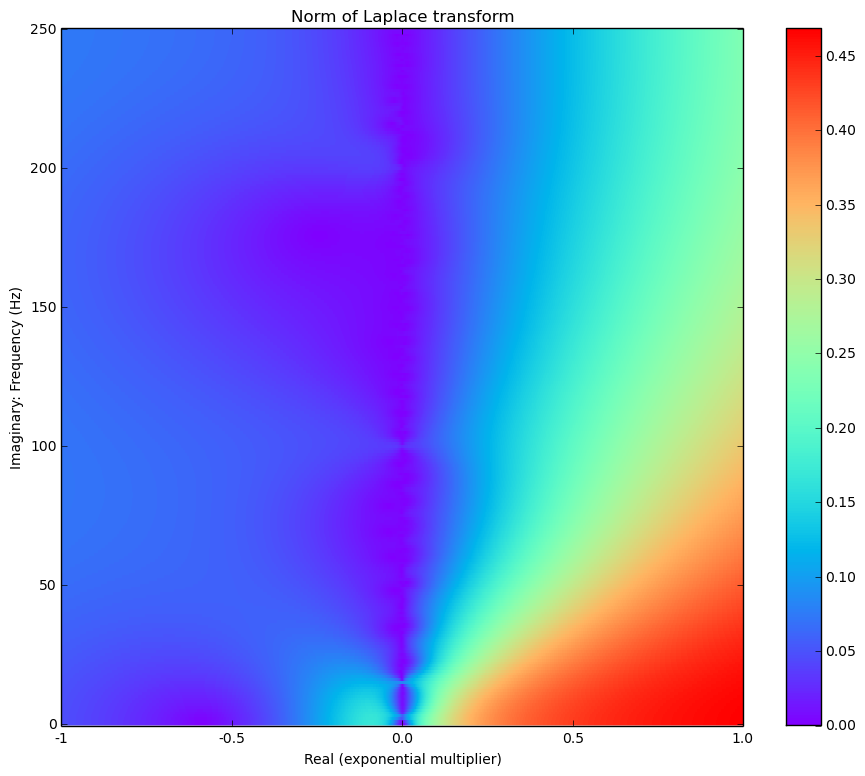

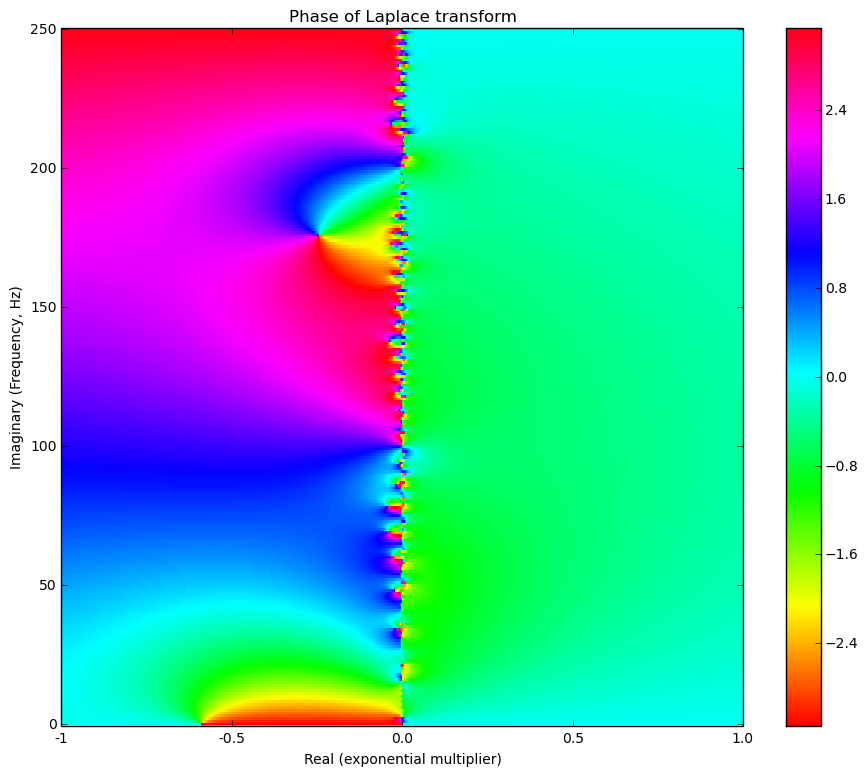

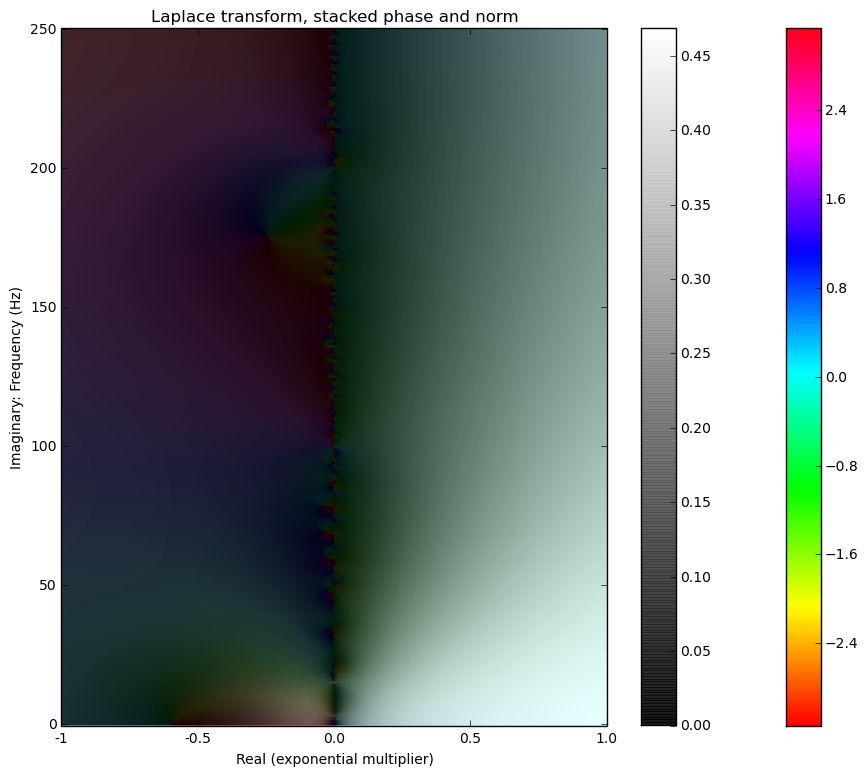

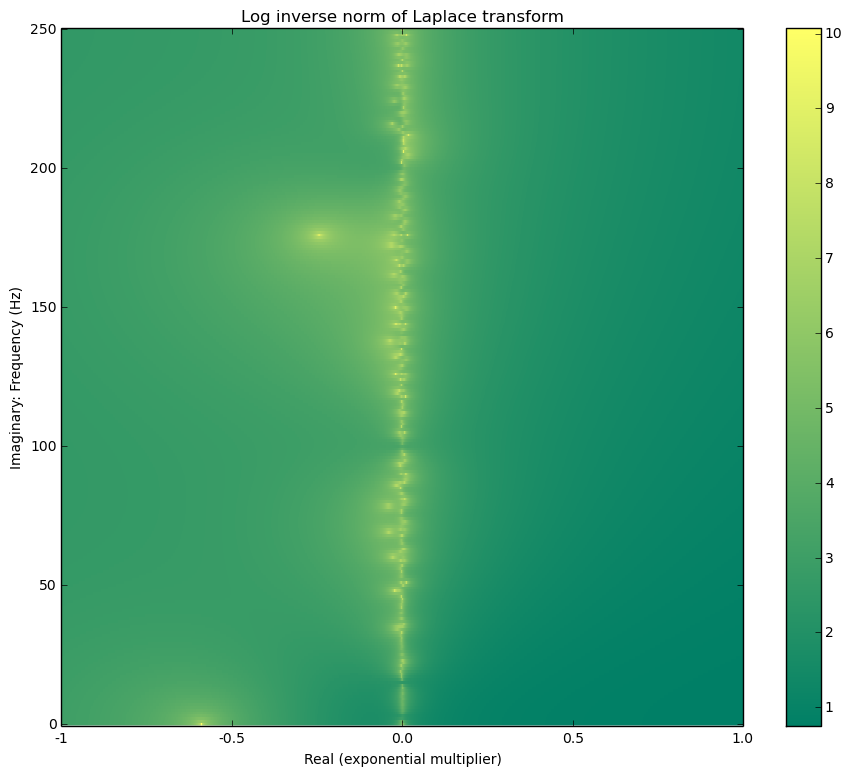

In [4]:

def laplace_transform(x, real_sigma_interval=np.arange(-1, 1 + 0.001, 0.001)):
    # Returns the Laplace transform where the first axis is the real range and second axis the imaginary range. 
    # Complex numbers are returned. 
    
    x = np.array(x)[::-1]  # The transform is from last timestep to first, so "x" is reversed
    
    d = []
    for sigma in real_sigma_interval:
        exp = np.exp( sigma*np.array(range(len(x))) )
        exp /= np.sum(exp)
        exponentiated_signal = exp * x
        # print (max(exponentiated_signal), min(exponentiated_signal))
        d.append(exponentiated_signal[::-1])  # re-reverse for straight signal
    
    # Now apply the imaginary part and "integrate" (sum)
    return np.array([np.fft.rfft(k) for k in d])


l = laplace_transform(x).transpose()

norm_surface = np.absolute(l)
angle_surface = np.angle(l)

# Plotting the transform: 

plt.figure(figsize=(11, 9))
plt.title("Norm of Laplace transform")
plt.imshow(norm_surface, aspect='auto', interpolation='none', cmap=plt.cm.rainbow)
plt.ylabel('Imaginary: Frequency (Hz)')
plt.xlabel('Real (exponential multiplier)')
plt.xticks([0, 500, 1000, 1500, 2000], [-1, -0.5, 0.0, 0.5, 1.0])
plt.gca().invert_yaxis()
plt.colorbar()

plt.figure(figsize=(11, 9))
plt.title("Phase of Laplace transform")
plt.imshow(angle_surface, aspect='auto', interpolation='none', cmap=plt.cm.hsv)
plt.ylabel('Imaginary (Frequency, Hz)')
plt.xlabel('Real (exponential multiplier)')
plt.xticks([0, 500, 1000, 1500, 2000], [-1, -0.5, 0.0, 0.5, 1.0])
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.figure(figsize=(11, 9))
plt.title("Laplace transform, stacked phase and norm")
plt.imshow(angle_surface, aspect='auto', interpolation='none', cmap=plt.cm.hsv)
plt.ylabel('Imaginary: Frequency (Hz)')
plt.xlabel('Real (exponential multiplier)')
plt.xticks([0, 500, 1000, 1500, 2000], [-1, -0.5, 0.0, 0.5, 1.0])
plt.colorbar()
plt.gca().invert_yaxis()
# Rather than a simple alpha channel option, I would have preferred a better transfer mode such as "multiply". 
plt.imshow(norm_surface, aspect='auto', interpolation='none', cmap=plt.cm.gray, alpha=0.9)
plt.ylabel('Imaginary: Frequency (Hz)')
plt.xlabel('Real (exponential multiplier)')
plt.xticks([0, 500, 1000, 1500, 2000], [-1, -0.5, 0.0, 0.5, 1.0])
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.figure(figsize=(11, 9))
plt.title("Log inverse norm of Laplace transform")
plt.imshow(-np.log(norm_surface), aspect='auto', interpolation='none', cmap=plt.cm.summer)
plt.ylabel('Imaginary: Frequency (Hz)')
plt.xlabel('Real (exponential multiplier)')
plt.xticks([0, 500, 1000, 1500, 2000], [-1, -0.5, 0.0, 0.5, 1.0])
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

## Other interesting stuff

If you want to know more about STFTs, FFTs, Laplace transforms and related signal processing stuff, you may want to watch those videos I gathered to understand the matter:

https://www.youtube.com/playlist?list=PLlp-GWNOd6m6gSz0wIcpvl4ixSlS-HEmr

## Connect with me

- https://ca.linkedin.com/in/chevalierg
- https://twitter.com/guillaume_che
- https://github.com/guillaume-chevalier/

In [5]:
# Let's convert this notebook to a README as the GitHub project's title page:
!jupyter nbconvert --to markdown Filtering.ipynb
!mv Filtering.md README.md

[NbConvertApp] Converting notebook Filtering.ipynb to markdown
[NbConvertApp] Support files will be in Filtering_files/
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Making directory Filtering_files
[NbConvertApp] Writing 8867 bytes to Filtering.md
